In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    auc, 
    confusion_matrix, 
    roc_auc_score, 
    roc_curve,
)
from sklearn.model_selection import (
    train_test_split, 
    StratifiedKFold,
    KFold,
    cross_val_score,
)
from sklearn.pipeline import (
    Pipeline,
)
from yellowbrick.classifier import (
    ConfusionMatrix, 
    ROCAUC,
)
from yellowbrick.model_selection import (
    LearningCurve,
)

/home/lukas/anaconda3/envs/handsonml/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
import sklearn, pandas, numpy
for lib in [sklearn, pandas, numpy]:
    print(lib.__name__, lib.__version__)

sklearn 0.23.1
pandas 1.0.5
numpy 1.18.5


### Getting the data

In [3]:
url = ('http://biostat.mc.vanderbilt.edu/'
       'wiki/pub/Main/DataSets/titanic3.xls')
titanic_vandebilt = pd.read_excel(url)

### Initial data profiling

In [4]:
titanic_vandebilt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


In [5]:
from pandas_profiling import ProfileReport

profile = ProfileReport(titanic_vandebilt, 
                        title="Vanderbilt University Medical Center (VUMC) Titanic dataset",
                        explorative=True)

profile.to_widgets()

In [6]:
titanic = titanic_vandebilt.copy()

titanic.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


### Exploring missing values

In [7]:
# Missing data in each collumn
titanic.isnull().sum().sort_values(ascending=False)

body         1188
cabin        1014
boat          823
home.dest     564
age           263
embarked        2
fare            1
ticket          0
parch           0
sibsp           0
sex             0
name            0
survived        0
pclass          0
dtype: int64

In [8]:
# Percentage of missing values in each collumn
titanic.isnull().mean().sort_values(ascending=False)

body         0.907563
cabin        0.774637
boat         0.628724
home.dest    0.430863
age          0.200917
embarked     0.001528
fare         0.000764
ticket       0.000000
parch        0.000000
sibsp        0.000000
sex          0.000000
name         0.000000
survived     0.000000
pclass       0.000000
dtype: float64

In [9]:
# Mask that will of use later 
rows_with_nans = titanic.isnull().any(axis='columns')
rows_with_nans.head()

0    True
1    True
2    True
3    True
4    True
dtype: bool

In [10]:
titanic.embarked.value_counts(dropna=False)

S      914
C      270
Q      123
NaN      2
Name: embarked, dtype: int64

We could see from `pandas_profiling` report that **pclass** and **sex** are categorical features with no missing values. However **embarked** (Point of embarktion) has two missing values. We could deal with these missing values in several ways:
1. We could impute them with the most common value of this feature.
2. We could drop these two values
3. We could ignore them and let `pd.get_dummies()` encode them as all-zeroes.
The latter approach could be used with **cabin** as it is also categorical (although with high cardinality)

### Dropping (seemingly) uninformative or *leaky* columns

In [11]:
# For extracting titles later in the analysis
passanger_names = titanic.name

columns = [
    'name',
    'ticket',
    'home.dest',
    'boat', 
    'body',
    'cabin'
]

titanic = titanic.drop(columns=columns)

1. **name** - Unless we perform some kind of NLP and external analysis like what were the most common names for upper-class individuals (that we assume would buy more expensive tickets on the higher decks and thus more likely to reach the rescue boats faster, we will not be able to fully take advantage of this column. We will use it to extract titles in hopes of determining their status though.
2. **ticket** - External analysis could be used to determine which cabins (with their proximity to the main deck/rescue boats) were purchased last, or whether the ticket the passanger bought were in the lower levels that would make the evacuation harder. We will not be doing that analysis at this time.
3. **home.dest** - Could be used similarly like the **ticket** column as described above.
4. **boat** - *Leaky* feature that indicates that the passanger was on a rescue boat.
5. **body** - *Leaky* feature that indicates that the passanger's body was found.
6. **cabin** - Could be used to determine the proximity to rescue boats but will not be used this analysis' current form due to a lot of missing values.

### Creating dummy columns

In [12]:
titanic = pd.get_dummies(titanic).drop(columns='sex_male')

titanic.columns

Index(['pclass', 'survived', 'age', 'sibsp', 'parch', 'fare', 'sex_female',
       'embarked_C', 'embarked_Q', 'embarked_S'],
      dtype='object')

In [13]:
import janitor

X, y = janitor.ml.get_features_targets(titanic, target_columns='survived')

### Creating train and test sets

In [14]:
def passenger_gender_proportions(data):
    return data.sex_female.sum() / len(data)

# Try train_test_split with/without stratify option
def try_out_statify_param(stratify=False, **kwargs):
    if not hasattr(kwargs, 'test_size'):
        kwargs['test_size'] = 0.2
    if not hasattr(kwargs, 'random_state'):
        kwargs['random_state'] = 42
    kwargs['stratify'] = X.sex_female if stratify is True else None
    
    return train_test_split(X, y, **kwargs)

In [15]:
(_, X_test_strat, _, _) = try_out_statify_param(stratify=True)
(_, X_test_rand, _, _) = try_out_statify_param(stratify=False)

In [16]:
# For comparing gender proportions in two ways of test-train dataset splitting:
gender_props = pd.Series(dtype=np.float64, name='Proportions of female passengers')

gender_props['overall'] = passenger_gender_proportions(titanic)
gender_props['random_w/_stratifying'] = passenger_gender_proportions(X_test_strat)
gender_props['random_w/o_stratifying'] = passenger_gender_proportions(X_test_rand)

In [17]:
rc = {
    'axes.grid': False,
    'axes.edgecolor': 'grey',
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.spines.left': False,
    'xtick.color': 'grey',
    'xtick.labelsize': 'small',
    'xtick.bottom': True,
    'xtick.major.size': 2.5,
    'ytick.color': 'grey',
    'ytick.major.size': 2.5,
    'ytick.left': False,
}

sns.set(style='whitegrid', rc=rc)

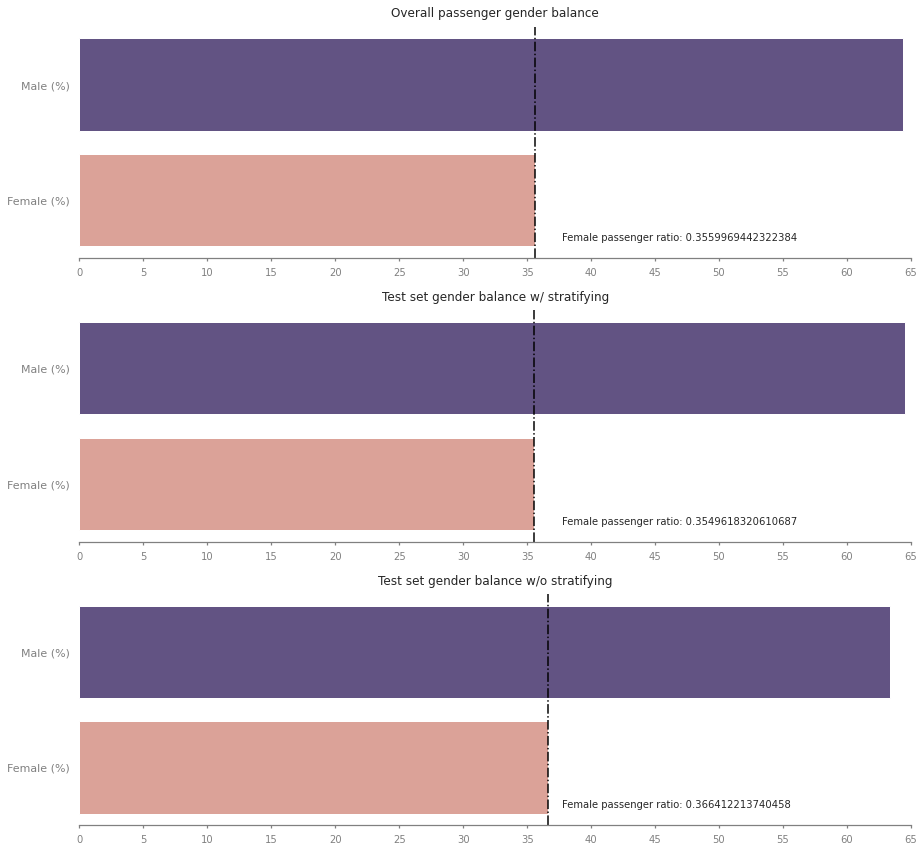

In [18]:
fig = plt.figure(figsize=(13, 12))
gs = fig.add_gridspec(3, 1)

ax = [fig.add_subplot(gs[0])]
for i in range(gs.nrows):
    if i > 0:
        ax.append(fig.add_subplot(gs[i], sharex=ax[0]))
    plt.setp(ax[i].xaxis.get_label(), visible=False)
    plt.setp(ax[i].yaxis.get_label(), visible=False)
    
data_sets = [titanic,  X_test_strat, X_test_rand]
titles = ['Overall passenger gender balance', 
          'Test set gender balance w/ stratifying', 
          'Test set gender balance w/o stratifying']
palette = sns.color_palette(['#5F4B8BFF', '#E69A8DFF'])

for data, ax, title, proportion in zip(data_sets, ax, titles, gender_props.values):
    sns.barplot(x='sex_female', y='sex_female', data=data, ax=ax, orient='horizontal',
                palette=palette,
                estimator=lambda x: len(x) / len(data) * 100)
    
    ax.set_title(title, pad=10)
    ax.axvline(x=proportion*100, ls='-.', lw=1.5, color='black')
    ax.annotate(f'Female passenger ratio: {proportion}' ,
                xy=(0.58, 0.075), xycoords='axes fraction', fontsize='small')
    ax.set_yticklabels(['Male (%)', 'Female (%)'])
    ax.set_xticks(np.arange(0,70,5))
    ax.set_xlim([0, 65])

gs.tight_layout(fig)
plt.show()

In [19]:
gender_props['strat_%_error'] = 100 * gender_props['random_w/_stratifying'] / gender_props['overall'] - 100
gender_props['rand_%_error'] = 100 * gender_props['random_w/o_stratifying'] / gender_props['overall'] - 100

In [20]:
gender_props

overall                   0.355997
random_w/_stratifying     0.354962
random_w/o_stratifying    0.366412
strat_%_error            -0.290764
rand_%_error              2.925663
Name: Proportions of female passengers, dtype: float64

Since the difference in female passenger proportions is around 3 times larger if we used completely random sampling for our test set instead of stratifying based on gender, we will use `test_train_split` with stratifying. Notice that the value of stratification of the test set diminishes as we increase the test set size.

In [21]:
X_train, X_test, y_train, y_test = try_out_statify_param(stratify=True)

### Imputing Data

In [22]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Dataframe of numerical columns of X_train
X_train_num = X_train.select_dtypes(include=[np.number])

imputer = IterativeImputer()
imputed_train_num = imputer.fit_transform(X_train_num)
imputed_test_num = imputer.transform(X_test[X_train_num.columns])

In [23]:
X_train_num.isna().any()

pclass        False
age            True
sibsp         False
parch         False
fare           True
sex_female    False
embarked_C    False
embarked_Q    False
embarked_S    False
dtype: bool

As we can see the only two numerical columns with missing values were **age** and **fare**. We can check if imputation was successful.

In [24]:
X_train_num_imputed = pd.DataFrame(imputed_train_num, 
                                   columns=X_train_num.columns, 
                                   index=X_train_num.index)
X_train_num_imputed.isna().any()

pclass        False
age           False
sibsp         False
parch         False
fare          False
sex_female    False
embarked_C    False
embarked_Q    False
embarked_S    False
dtype: bool

After data imputation, no numerical columns are missing. We might want to see which feature vectors required these imputations.

In [25]:
missing_fare_ix = X_train_num[X_train_num.fare.isnull()].index
missing_age_ix = X_train_num[X_train_num.age.isnull()].index

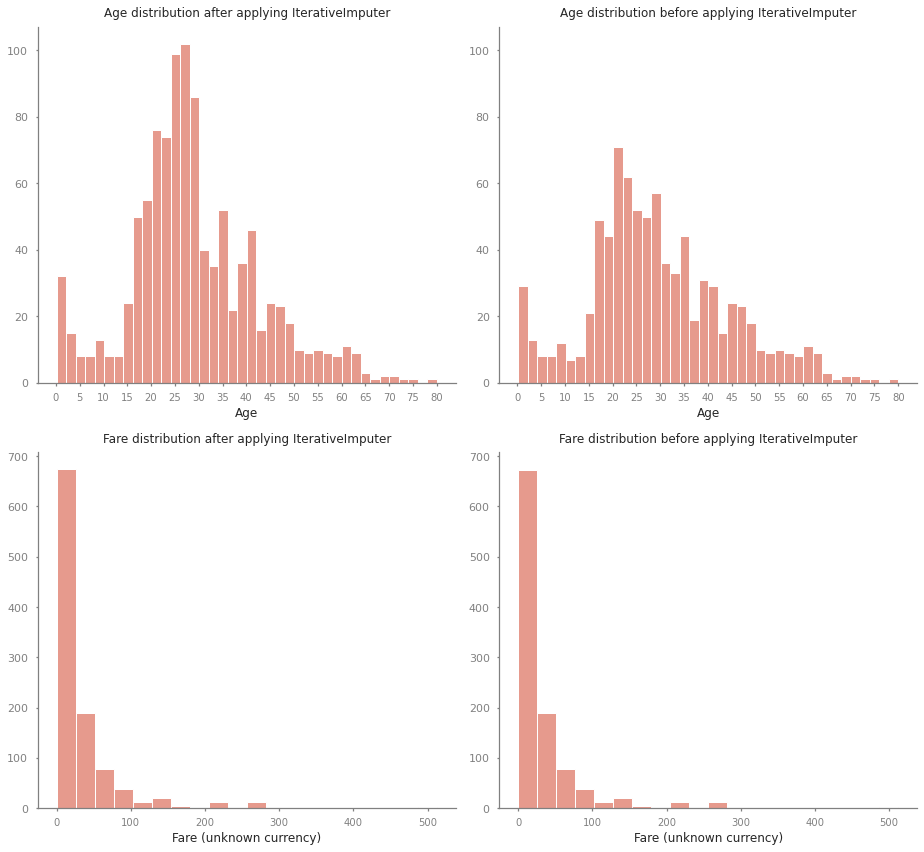

In [26]:
rc.update({
    'axes.spines.left': True,
    'ytick.left': True,
})

sns.set(style='whitegrid', rc=rc)

fig = plt.figure(figsize=(13,12))
gs = fig.add_gridspec(2, 2)

axes = []
for row in range(gs.nrows):
    axes_col = []
    for col in range(gs.ncols):
        if col == 0:
            ax = fig.add_subplot(gs[row,col])
        else:
            ax = fig.add_subplot(gs[row,col], sharey=axes_col[0])
        plt.setp(ax.yaxis.get_label(), visible=False)
        axes_col.append(ax)
    axes.append(axes_col)


hist_kws=dict(alpha=1)

# Plotting imputed age data
titles = ['Age distribution after applying IterativeImputer', 
          'Age distribution before applying IterativeImputer']
for data, title, ax in zip([X_train_num_imputed, X_train_num], titles, axes[:][0]):
    bins=40
    sns.distplot(data['age'], kde=False, bins=bins, 
                 color=palette[1], hist_kws=hist_kws, ax=ax)
    ax.set_title(title, pad=10)
    ax.set_xlabel('Age')
    ax.set_xticks(np.arange(0, 80+1, 5))
    
    
# Plotting imputed fare data
titles = ['Fare distribution after applying IterativeImputer', 
          'Fare distribution before applying IterativeImputer']
for data, title, ax in zip([X_train_num_imputed, X_train_num], titles, axes[:][1]):
    sns.distplot(data['fare'], kde=False, bins=20, 
                 color=palette[1], hist_kws=hist_kws, ax=ax)
    ax.set_title(title, pad=10)
    ax.set_xlabel('Fare (unknown currency)')
    
gs.tight_layout(fig)
plt.show()

We can see that **age** feature histogram has visible changes after performing data imputation, but **fare** histogram is virtually identical. We can confirm that the imputation is still working by highlighting (or remembering, from `pandas_profiling` observations) the fact that only one **fare** value needed to be imputed, thus it's likely it's not observable in the histogram comparison.

In [27]:
X_train_num_imputed.loc[missing_fare_ix]

,pclass,age,sibsp,parch,fare,sex_female,embarked_C,embarked_Q,embarked_S
1225,3.0,60.5,0.0,0.0,0.025319,0.0,0.0,0.0,1.0


In [28]:
X_train_num.fare.describe()

count    1046.000000
mean       32.410726
std        49.447980
min         0.000000
25%         7.895800
50%        14.400000
75%        30.500000
max       512.329200
Name: fare, dtype: float64

The imputed **fare** value is far below the 25% quantile.

We might be interested to visualize the imputed values from the chart above on top of non-imputed values to better grasp the scale and impact and inner workings of `IterativeImputer` that we used.

In [29]:
age_imputed = X_train_num_imputed.copy()
age_imputed['is_imputed'] = False
age_imputed.loc[missing_age_ix, 'is_imputed'] = True

fare_imputed = X_train_num_imputed.copy()
fare_imputed['is_imputed'] = False
fare_imputed.loc[missing_fare_ix, 'is_imputed'] = True

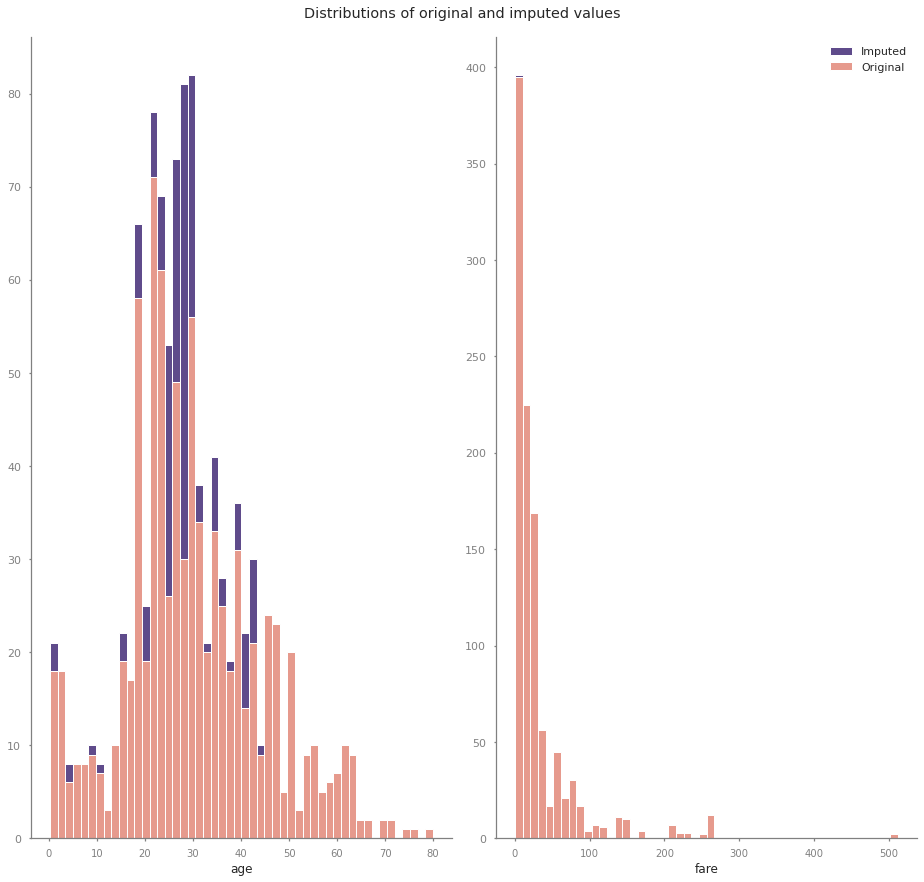

In [30]:
fig = plt.figure(figsize=(13,12))
gs = fig.add_gridspec(1, 2)

ax = [fig.add_subplot(gs[col]) for col in range(gs.ncols)]
kwargs = dict(kde=False, bins=50, hist_kws={'alpha':1.0})

# For `age` attribute
imputed_plot = sns.distplot(age_imputed.age, color=palette[0], ax=ax[0], **kwargs)
original_plot = sns.distplot(age_imputed[age_imputed.is_imputed==False].age, 
                             color=palette[1], ax=ax[0], **kwargs)

# For `fare` attribute
imputed_plot = sns.distplot(fare_imputed.fare, color=palette[0], ax=ax[1], 
                            label='Imputed', **kwargs)
original_plot = sns.distplot(fare_imputed[fare_imputed.is_imputed==False].fare, 
                             label='Original', color=palette[1], ax=ax[1], **kwargs)

fig.suptitle('Distributions of original and imputed values', y=1.02)
plt.legend()
gs.tight_layout(fig)
plt.show()

We can see the single imputed **fare** value in the first bin of the right historgram more clearly now.

### Normalizing Data

In [31]:
X_train_num.columns

Index(['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex_female', 'embarked_C',
       'embarked_Q', 'embarked_S'],
      dtype='object')

In [32]:
# We are not going to normalize dummy columns, so we will explicitly
# specify which columns we want to be normalized

cols_to_normalize = ['pclass', 'age', 'sibsp', 'parch', 'fare']

In [33]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_train_num = scaler.fit_transform(X_train_num_imputed[cols_to_normalize])
# We never turned test data back to a DataFrame so pass the imputed array and use array indexing
scaled_test_num = scaler.transform(imputed_test_num[:, :len(cols_to_normalize)]) 

In [34]:
# Turning back to a DataFrame
X_train_num_normalized = pd.DataFrame(scaled_train_num, columns=cols_to_normalize)

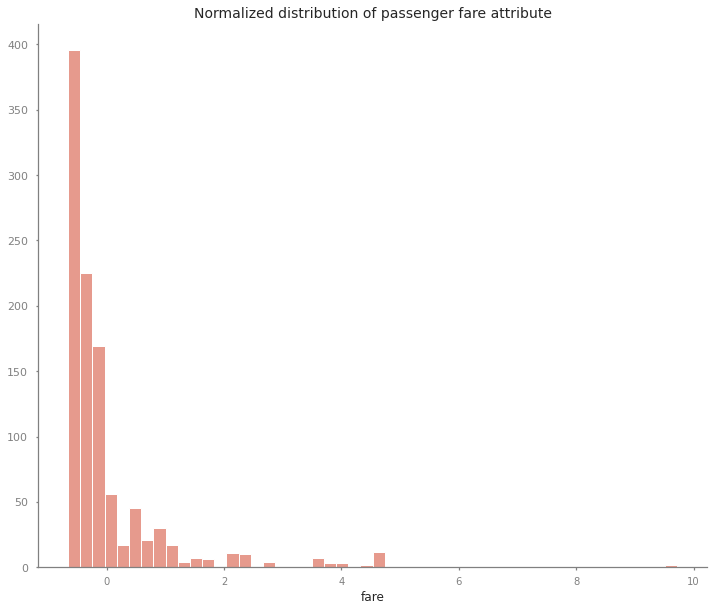

In [35]:
fig = plt.figure(figsize=(12,10))
sns.distplot(X_train_num_normalized.fare, color=palette[1], **kwargs)
plt.title('Normalized distribution of passenger fare attribute', size=14)
plt.show()

### Refactoring

As a chance to learn decorators, we will first define a wrapper to measure the performances of approaches described in the book and my version of it.

In [36]:
from time import time
import functools

def measure_time(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        t0 = time()
        result = func(*args, **kwargs)
        t1 = time() - t0
        print(f'{func.__name__} running time: {t1}')
        return result
    return wrapper

Original (with minor spacing or formatting tweaks) code that was proposed to use in the book:

In [37]:
def tweat_titanic(df):
    df = (df.drop(columns=['name', 'ticket', 'home.dest', 'boat', 'body', 'cabin'])
            .pipe(pd.get_dummies, drop_first=True))
    return df


def get_train_test_X_y(df, y_col, size=0.3, std_cols=None):
    y = df[y_col]
    X = df.drop(columns=y_col)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=42)
    
    cols = X.columns
    num_cols = ['pclass', 'age', 'sibsp', 'parch', 'fare']
    
    fi = IterativeImputer()
    X_train.loc[:, num_cols] = fi.fit_transform(X_train[num_cols])
    X_test.loc[:, num_cols] = fi.transform(X_test[num_cols])
    
    if std_cols:
        std = StandardScaler()
        X_train.loc[:, std_cols] = std.fit_transform(X_train[std_cols])
        X_test.loc[:, std_cols] = std.transform(X_test[std_cols])
        
    return X_train, X_test, y_train, y_test


# Usage
@measure_time
def book_usage():
    ti_df = tweat_titanic(titanic_vandebilt.copy())
    std_cols = 'pclass,age,sibsp,fare'.split(',')
    return get_train_test_X_y(ti_df, 'survived', std_cols=std_cols) 

X_train_b, X_test_b, y_train_b, y_test_b = book_usage()

book_usage running time: 0.04257059097290039


/home/lukas/anaconda3/envs/handsonml/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/lukas/anaconda3/envs/handsonml/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/lukas/anaconda3/envs/handsonml/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

My solution using pipelines:

In [38]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

numerical_feat_preprocessing_pipeline = Pipeline([
    ('iter_imputer', IterativeImputer()),
    ('std_scaler', StandardScaler())
])

# Isn't used because drop='first' and handle_unknown='ignore' cannot be used together
# -----
categorical_feat_preprocessing_pipeline = Pipeline([
    ('1h_encoder', OneHotEncoder(drop='first', handle_unknown='error'))
])

num_cols = ['pclass', 'age', 'sibsp', 'parch', 'fare']
cat_cols = ['sex', 'embarked']

full_preprocessing_pipeline = ColumnTransformer([
    ('numerical', numerical_feat_preprocessing_pipeline, num_cols),
    ('categorical', categorical_feat_preprocessing_pipeline, cat_cols)
])
# -----

@measure_time
def self_usage():
    titanic = tweat_titanic(titanic_vandebilt.copy())
    
    X, y = janitor.ml.get_features_targets(titanic, target_columns='survived')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                        random_state=42, stratify=y)
    
    X_train = numerical_feat_preprocessing_pipeline.fit_transform(X_train)
    X_test = numerical_feat_preprocessing_pipeline.transform(X_test)
    
    return (X_train, X_test, y_train, y_test)

X_train, X_test, y_train, y_test = self_usage()

self_usage running time: 0.1368851661682129


Solution provided in the book runs faster and is considerably more readable on screen rather than on the small booklet. Runtime complains because of usage of `.loc`.

My version didn't turn out to be as I wanted - mainly because of missing values in **embarked** column, we cannot drop and ignore columns using `sklearn.preprocessing.OneHotEncoder`. Similar issue with these parameters were found in a blog post [1]. I opted to re-use `pd.get_dummies` instead. I also used stratified train test split with additional parameter in `sklearn.model_selection.train_test_split`. Lastly, the returned values are ndarrays instead of DataFrames, as that's what sklearn's transformers normally expect.

### Baseline Model

In [39]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score

baseline_model = DummyClassifier(strategy='stratified', random_state=42)
baseline_model.fit(X_train, y_train)

y_pred = baseline_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f"""{baseline_model.__str__()}:
Accuracy: {accuracy}
Precision: {precision}
""")

DummyClassifier(random_state=42, strategy='stratified'):
Accuracy: 0.5419847328244275
Precision: 0.40131578947368424



In [40]:
# Same as accuracy_score
baseline_model.score(X_test, y_test)

0.5419847328244275

### Trying Out Various ML Algorithm Families

In the book it is suggested to concatenate the test set and train set back together because we are not going to use k-fold cross validation for tuning model hyperparameters, but for checking performances of the models from various ML algorithm families. 

However, we will not do that here and we will treat the already-derived train set as a holdout set.

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

for model in [
    DummyClassifier, 
    LogisticRegression, 
    DecisionTreeClassifier, 
    KNeighborsClassifier,
    GaussianNB,
    SVC,
    RandomForestClassifier,
    XGBClassifier
]:
    classifier = model()
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    cv_scores = cross_val_score(classifier, X_train, y_train, scoring='roc_auc', cv=kfold, n_jobs=-1)
    print(f'{model.__name__:22} AUC: {cv_scores.mean():.3f} STD: {cv_scores.std():.2f}')

DummyClassifier        AUC: 0.505 STD: 0.02
LogisticRegression     AUC: 0.827 STD: 0.05
DecisionTreeClassifier AUC: 0.738 STD: 0.06
KNeighborsClassifier   AUC: 0.822 STD: 0.06
GaussianNB             AUC: 0.807 STD: 0.06
SVC                    AUC: 0.822 STD: 0.06
RandomForestClassifier AUC: 0.842 STD: 0.05
XGBClassifier          AUC: 0.835 STD: 0.04


In [43]:
from mlxtend.classifier import StackingClassifier

classifiers = [model() for model in [
    LogisticRegression, DecisionTreeClassifier, GaussianNB, 
    KNeighborsClassifier, SVC, RandomForestClassifier, XGBClassifier
]]

stack = StackingClassifier(classifiers=classifiers, 
                           meta_classifier=LogisticRegression(), 
                           use_clones=False)

kfold = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(stack, X_train, y_train, scoring='roc_auc', cv=kfold, n_jobs=-1)
print(f'{stack.__class__.__name__:22} AUC: {cv_scores.mean():.3f} STD: {cv_scores.std():.2f}')

StackingClassifier     AUC: 0.786 STD: 0.06


In [44]:
for classifier in [LogisticRegression(), KNeighborsClassifier(), GaussianNB(), 
                   SVC(), RandomForestClassifier(), XGBClassifier(), stack]:
    
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    
    print(f'{classifier.__class__.__name__:22} ACC: {accuracy:.3f} PRC {precision:.3f}')

LogisticRegression     ACC: 0.817 PRC 0.779
KNeighborsClassifier   ACC: 0.796 PRC 0.727
GaussianNB             ACC: 0.796 PRC 0.727
SVC                    ACC: 0.827 PRC 0.785
RandomForestClassifier ACC: 0.774 PRC 0.699
XGBClassifier          ACC: 0.809 PRC 0.748
StackingClassifier     ACC: 0.791 PRC 0.715


### Creating a Model

In [67]:
def evaluate_model(model_instance, scorers):
    # Check if X_test and y_test are available as free variables
    if not set(['X_test', 'y_test']).issubset(set(dir())):
        y_pred = model_instance.predict(X_test)
        results_string = f'{model_instance.__class__.__name__:22}'
        for scorer in scorers:
            metric_name, func = scorer
            score = func(y_test, y_pred)
            results_string += f' {metric_name:3}: {score:.3f}'
        print(results_string)
    else:
        raise ReferenceError('X_test, y_test not in scope')

In [70]:
rf_cls = RandomForestClassifier(n_estimators=100, random_state=42)
rf_cls.fit(X_train, y_train)

evaluate_model(rf_cls, [('ACC', accuracy_score), ('PRC', precision_score)])

RandomForestClassifier ACC: 0.779 PRC: 0.709
